# Ambien't

In [1]:

%matplotlib inline
import sys, os
# unfortunately I was not able to run it on GPU due to overflow problems

import theano

from collections import OrderedDict
from copy import deepcopy
import numpy as np
from time import time
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.datasets import fetch_20newsgroups
import matplotlib.pyplot as plt
import seaborn as sns
from theano import shared
import theano.tensor as tt
from theano.sandbox.rng_mrg import MRG_RandomStreams

import pymc3 as pm
from pymc3 import math as pmmath
from pymc3 import Dirichlet
from pymc3.distributions import Interpolated
from pymc3.distributions.transforms import t_stick_breaking
plt.style.use('seaborn-darkgrid')

In [2]:
import scanpy.api as sc
import pandas as pd
adata = sc.read_10x_mtx('/home/mt/Downloads/E40_motor_Out/outs/raw_gene_bc_matrices/refdata-celranger-mmul8-toplevel/',cache=True)
bcs=list(pd.read_csv('/home/mt/Downloads/E40_motor_Out/outs/filtered_gene_bc_matrices/refdata-celranger-mmul8-toplevel/barcodes.tsv').iloc[:,0])
#adata = sc.read_10x_h5('/home/mt/code/data/AlignedOrangutanOrganoid/Exonic/orangutanorganoid_Out/outs/filtered_gene_bc_matrices_h5.h5','refdata-celranger-Pabe2-toplevel')
adata.var_names_make_unique()
sc.pp.filter_genes(adata, min_cells=50,inplace=True)
sc.pp.filter_cells(adata,min_counts=5,inplace=True)
adata=adata[adata.obs.n_counts.argsort(),:]


In [3]:
#adata._inplace_subset_obs(np.random.choice(adata.obs.index,30000,replace=False))
#adata._inplace_subset_var(np.random.choice(adata.var.index,5000,replace=False))
#sc.pp.filter_genes(adata, min_cells=50,inplace=True)
#sc.pp.filter_cells(adata,min_counts=5,inplace=True)
adata

View of AnnData object with n_obs × n_vars = 113535 × 10211 
    obs: 'n_counts'
    var: 'gene_ids', 'n_cells'

In [4]:
from scipy.stats import gaussian_kde
ambient_counts=np.log10(adata[[x not in bcs for x in adata.obs.index] ,:].obs.n_counts)

def from_epdf(param, ambient_counts):
    smin, smax = np.min(ambient_counts), np.max(ambient_counts)
    width = smax - smin
    x = np.linspace(smin, smax, 200)
    y = gaussian_kde(ambient_counts)(x)
    x = np.concatenate([[-1e9,-100,0], x, [x[-1] + np.log10(10)]])
    y = np.concatenate([[1e-1000,1e-200,1e-2], y, [1e-20]])
    #print(x)
    #print(y)
    sns.scatterplot(x,y)
    plt.show()
    return Interpolated(param, x, y)

In [5]:
cell_inds=np.where([x in bcs for x in adata.obs.index])[0]
junk_inds=np.where([x not in bcs for x in adata.obs.index])[0]



In [6]:
betaAmbient = adata[junk_inds,:].X.sum(axis=0)/adata[junk_inds,:].X.sum(axis=1).sum()

In [7]:
feature_names=list(adata.var.index)
tf=adata.X[cell_inds,:]


In [8]:
#import sklearn
#ldaM=sklearn.decomposition.LatentDirichletAllocation(n_components=10,learning_method="online",verbose=1,n_jobs=-1)
#ldaM.fit(tf)
#doc_topic=ldaM.transform(tf)

In [9]:
n_samples_tr = tf.shape[0]
n_samples_te = tf.shape[0] - n_samples_tr
docs_tr = tf[:n_samples_tr, :]
docs_te = tf[n_samples_tr:, :]
print('Number of docs for training = {}'.format(docs_tr.shape[0]))
print('Number of docs for test = {}'.format(docs_te.shape[0]))

n_tokens = np.sum(docs_tr[docs_tr.nonzero()])
print('Number of tokens in training set = {}'.format(n_tokens))
print('Sparsity = {}'.format(
    len(docs_tr.nonzero()[0]) / float(docs_tr.shape[0] * docs_tr.shape[1])))

Number of docs for training = 1140
Number of docs for test = 0
Number of tokens in training set = 12007794.0
Sparsity = 0.2796262029081125


In [10]:
n_topics=10
L = (.1 / n_topics) * np.ones((tf.shape[0], n_topics))
#L[junk_inds,:]=1e-50
#L[junk_inds,L.shape[1]-1]=1
L=pm.floatX(L)

In [82]:
def logp_lda_doc(doc_t,theta,beta,density,betaAmbient=None):
    """Returns the log-likelihood function for given documents.

    K : number of topics in the model
    V : number of words (size of vocabulary)
    D : number of documents (in a mini-batch)

    Parameters
    ----------
    beta : tensor (K x V)
        Word distributions.
    theta : tensor (D x K)
        Topic distributions for documents.
    dixs : which doc
    vixs : which word
    vfreqs : frequency of doc x word
    """
    def ll_docs_f(inds):
        inds=inds.eval().astype('int32')
        docs=shared(doc_t[inds,:].toarray())
        print(docs.eval())
        dixs, vixs = docs.nonzero()
        vfreqs = docs[dixs, vixs]
        if betaAmbient is not None:
            boundBeta=tt.concatenate([beta,betaAmbient],axis=0)
        else:
            boundBeta=beta
        '''tt.printing.Print('dixs')(dixs)
        tt.printing.Print('docT')(inds.astype('int32'))
        tt.printing.Print('LFull')(tt.log10(L))
        tt.printing.Print('L')(tt.log10(L[inds,:][dixs]))
        tt.printing.Print('Lsummax')(tt.max(tt.sum(tt.log10(L[dixs]),axis=1)))
        tt.printing.Print('Lsubsummax')(tt.max(tt.sum(tt.log10(L[inds,:][dixs]),axis=1)))
        tt.printing.Print('thetafull')(theta.shape)
        tt.printing.Print('theta')(tt.log10(theta[dixs]))
        tt.printing.Print('beta')(tt.log10(beta.T[vixs]))'''
        ll_docs = vfreqs * pmmath.logsumexp(
            tt.log10(theta) + tt.log10(boundBeta.T[vixs]),
            axis=1).ravel()
        #*(tt.sum(ambient.distribution.logp(tt.log10(tt.sum(docs,axis=1)*theta[0:,theta.shape[1]-1]))) / beta.shape[1])
        # Per-word log-likelihood times num of tokens in the whole dataset * Log likelihood of 
        #tt.printing.Print('prob')(ambient.distribution.logp(2))
        #tt.printing.Print('docs')(docs.shape)
        #tt.printing.Print('logsum')(tt.log10(tt.sum(docs,axis=1)))
        #tt.printing.Print('logsum+theta')(ambient.distribution.logp(tt.log10(tt.sum(docs,axis=1)*theta[:,theta.shape[1]-1]))) - tt.log10(beta.shape[1])
        #tt.printing.Print('distout')((tt.sum(ll_docs) / (tt.sum(vfreqs)+1e-9) * n_tokens))
        #tt.printing.Print('likelihood')((tt.sum(ll_docs) / (tt.sum(vfreqs)+1e-9) * n_tokens)+(tt.sum(ambient.distribution.logp(tt.log10(tt.sum(docs,axis=1)*subtheta[:,theta.shape[1]-1]))) - tt.log10(beta.shape[1])))
        #tt.printing.Print('lldocs')(ll_docs)
        #return ((tt.sum(ll_docs) / (tt.sum(vfreqs)+1e-9) * n_tokens))
        #tt.printing.Print('final')((tt.sum(ll_docs) / (tt.sum(vfreqs)+1e-9) * n_tokens)+(tt.sum(ambient.distribution.logp(tt.log10((tt.sum(docs,axis=1)+1e-9)*theta[:,theta.shape[1]-1])))))
        return ((tt.sum(ll_docs) / (tt.sum(vfreqs)+1e-9) * n_tokens)+(tt.sum(ambient.distribution.logp(tt.log10((tt.sum(docs,axis=1)+1e-9)*theta[theta.size-1])))))
    
    return ll_docs_f


/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/pymc3/data.py:245: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  self.shared = theano.shared(data[in_memory_slc])


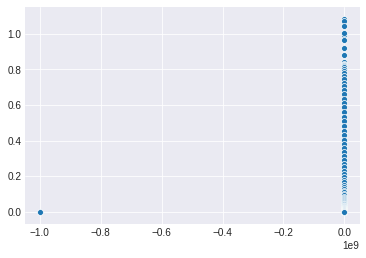

[[ 0.  0.  1. ...  1. 45.  0.]]
[[ 0.  0.  1. ...  1. 45.  0.]]
[[ 0.  0.  1. ...  1. 45.  0.]]


/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [83]:
n_topics = 10
# we have sparse dataset. It's better to have dense batch so that all words occur there
minibatch_size = 1
n_words=tf.shape[1]

# defining minibatch
#Can't load these arrays
doc_t_minibatch = pm.Minibatch(list(range(docs_tr.shape[0])), minibatch_size)

doc_t = shared(np.random.choice(list(range(docs_tr.shape[0]-1)),minibatch_size))
with pm.Model() as model:
    theta = Dirichlet('theta', a=pm.floatX((1.0 / n_topics) * np.ones((n_topics))),
                      shape=( n_topics), transform=t_stick_breaking(1e-9),
                      # do not forget scaling
                      total_size=n_topics)
    beta = Dirichlet('beta', a=pm.floatX((1.0 / (n_topics-1)) * np.ones((n_topics-1, n_words))),
                     shape=(n_topics-1, n_words), transform=t_stick_breaking(1e-9))
    ambient=from_epdf('ambient',ambient_counts)
    # Note, that we defined likelihood with scaling, so here we need no additional `total_size` kwarg
    #doc=m.DensityDist('doc', logp_lda_doc(docs_tr,beta, theta,ambient,shared(betaAmbient)), observed=doc_t_minibatch)
    doc = pm.DensityDist('doc', logp_lda_doc(docs_tr,theta,beta,ambient,shared(betaAmbient)), observed=doc_t)

In [84]:
doc_t_minibatch.eval()

array([92])

In [91]:
class LDAEncoder:
    """Encode (term-frequency) document vectors to variational means and (log-transformed) stds.
    """
    def __init__(self, n_words, n_hidden, n_topics, p_corruption=0, random_seed=1):
        rng = np.random.RandomState(random_seed)
        self.n_words = n_words
        self.n_hidden = n_hidden
        self.n_topics = n_topics
        self.w0 = shared(0.01 * rng.randn(n_words, n_hidden).ravel(), name='w0')
        self.b0 = shared(0.01 * rng.randn(n_hidden), name='b0')
        self.w1 = shared(0.01 * rng.randn(n_hidden, 2 * (n_topics - 1)).ravel(), name='w1')
        self.b1 = shared(0.01 * rng.randn(2 * (n_topics - 1)), name='b1')
        self.rng = MRG_RandomStreams(seed=random_seed)
        self.p_corruption = p_corruption

    def encode(self, xs):
        if 0 < self.p_corruption:
            dixs, vixs = xs.nonzero()
            mask = tt.set_subtensor(
                tt.zeros_like(xs)[dixs, vixs],
                self.rng.binomial(size=dixs.shape, n=1, p=1-self.p_corruption)
            )
            xs_ = xs * mask
        else:
            xs_ = xs

        w0 = self.w0.reshape((self.n_words, self.n_hidden))
        w1 = self.w1.reshape((self.n_hidden, 2 * (self.n_topics - 1)))
        hs = tt.nnet.relu(xs_.dot(w0) + self.b0)
        zs = hs.dot(w1) + self.b1
        zs_mean = zs[:, :(self.n_topics - 1)]
        zs_rho = zs[:, (self.n_topics - 1):]
        return {'mu': zs_mean, 'rho':zs_rho}

    def get_params(self):
        return [self.w0, self.b0, self.w1, self.b1]

In [92]:
encoder = LDAEncoder(n_words=n_words, n_hidden=500, n_topics=n_topics, p_corruption=0.0)
print('Built Encoder')
local_RVs = OrderedDict([(theta, encoder.encode(shared(docs_tr[doc_t.eval(),:].toarray())))])
local_RVs

Built Encoder


OrderedDict([(theta,
              {'mu': Subtensor{::, :int64:}.0,
               'rho': Subtensor{::, int64::}.0})])

In [93]:
encoder_params = encoder.get_params()
encoder_params

[w0, b0, w1, b1]

In [94]:
η = .1
s = shared(η)
def reduce_rate(a, h, i):
    s.set_value(η/((i/minibatch_size)+1)**.7)

with model:
    approx = pm.MeanField(local_rv=local_RVs)
    approx.scale_cost_to_minibatch = False
    inference = pm.KLqp(approx)
    inference.fit(10000, callbacks=[reduce_rate], obj_optimizer=pm.sgd(learning_rate=s),
              more_obj_params=encoder_params, total_grad_norm_constraint=200,
              more_replacements={doc_t: doc_t_minibatch})

  0%|          | 0/10000 [00:00<?, ?it/s]/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Average Loss = 3.237e+07:   0%|          | 2/10000 [00:00<20:05,  8.30it/s]


FloatingPointError: NaN occurred in optimization. 
The current approximation of RV `theta_stickbreaking__`.ravel()[0] is NaN.

In [ ]:
plt.plot(approx.hist[10:]);

In [329]:
approx.sample_node(inference.approx.model.theta, 100,).mean(0).eval()

array([0.06934945, 0.06873255, 0.07078464, 0.06959092, 0.07133257,
       0.07290512, 0.07179587, 0.0707227 , 0.07056266, 0.36422351])

In [303]:
approx.sample_node(inference.approx.model.theta, 100,  more_replacements={doc_t: doc_t_minibatch}).mean(0).eval()

array([0.0944035 , 0.09134296, 0.0915113 , 0.09267247, 0.09314639,
       0.09242378, 0.09101122, 0.09104603, 0.08936998, 0.17307238])

In [90]:
samples = pm.sample_approx(approx, draws=100)
beta_pymc3 = samples['beta'].mean(axis=0)

In [79]:
np.corrcoef(beta_pymc3)

array([[1.        , 0.98892944, 0.98909162, 0.98891689, 0.9884047 ,
        0.98879591, 0.98933502, 0.98890987, 0.98799376],
       [0.98892944, 1.        , 0.98774385, 0.9878126 , 0.98920378,
        0.98768933, 0.9886877 , 0.98857251, 0.98761686],
       [0.98909162, 0.98774385, 1.        , 0.98810451, 0.98828765,
        0.98805738, 0.98813817, 0.98765978, 0.98704209],
       [0.98891689, 0.9878126 , 0.98810451, 1.        , 0.98914141,
        0.98876556, 0.98894112, 0.98816537, 0.98875619],
       [0.9884047 , 0.98920378, 0.98828765, 0.98914141, 1.        ,
        0.98851776, 0.98851029, 0.98850113, 0.98797709],
       [0.98879591, 0.98768933, 0.98805738, 0.98876556, 0.98851776,
        1.        , 0.98814196, 0.98838514, 0.98807352],
       [0.98933502, 0.9886877 , 0.98813817, 0.98894112, 0.98851029,
        0.98814196, 1.        , 0.9890352 , 0.98861532],
       [0.98890987, 0.98857251, 0.98765978, 0.98816537, 0.98850113,
        0.98838514, 0.9890352 , 1.        , 0.98834368],


In [105]:
def calc_pp(ws, thetas, beta, wix):
    """
    Parameters
    ----------
    ws: ndarray (N,)
        Number of times the held-out word appeared in N documents.
    thetas: ndarray, shape=(N, K)
        Topic distributions for N documents.
    beta: ndarray, shape=(K, V)
        Word distributions for K topics.
    wix: int
        Index of the held-out word

    Return
    ------
    Log probability of held-out words.
    """
    return ws * np.log(thetas.dot(beta[:, wix]))

def eval_lda(transform, beta, docs_te, wixs):
    """Evaluate LDA model by log predictive probability.

    Parameters
    ----------
    transform: Python function
        Transform document vectors to posterior mean of topic proportions.
    wixs: iterable of int
        Word indices to be held-out.
    """
    lpss = []
    docs_ = deepcopy(docs_te)
    thetass = []
    wss = []
    total_words = 0
    for wix in wixs:
        thetas = transform(docs_)
        print(thetas.shape)
        print(thetas)

    # Log-probability
    lp = np.sum(np.hstack(lpss)) / total_words

    return {
        'lp': lp,
        'thetass': thetass,
        'beta': beta,
        'wss': wss
    }

inp = tt.vector()
sample_vi_theta = theano.function(
    [inp],
    approx.sample_node(approx.model.theta, 100,  more_replacements={doc_t: inp}).mean(0),
    on_unused_input='ignore'
)
def transform_pymc3(docs):
    return sample_vi_theta(docs)

In [106]:
beta_pymc3 = approx.sample(100)[beta].mean(axis=0)
result_pymc3 = eval_lda(transform_pymc3, beta_pymc3, list(range(docs_tr.shape[0])), np.arange(100))

(24, 10)
[[0.06596214 0.06454413 0.06594213 0.07127647 0.07012323 0.06421602
  0.06729053 0.06885107 0.0617733  0.40002098]
 [0.06574278 0.06456989 0.06429776 0.06953203 0.07134382 0.06648125
  0.06508849 0.06671116 0.05638789 0.40984493]
 [0.06808918 0.0697883  0.07775653 0.08008026 0.07554045 0.07471844
  0.07514973 0.08056047 0.065627   0.33268965]
 [0.0616615  0.06329995 0.06152977 0.0695514  0.06637441 0.06179923
  0.06403772 0.06778055 0.057058   0.42690748]
 [0.06438207 0.06330777 0.06323986 0.06734259 0.06661573 0.06237214
  0.06349823 0.06419245 0.05756111 0.42748806]
 [0.06430473 0.06639534 0.06590997 0.07292658 0.07118216 0.06379032
  0.06566055 0.07004368 0.05899204 0.40079463]
 [0.06470028 0.06458882 0.06316524 0.07170771 0.06628515 0.06506834
  0.0629187  0.06634516 0.05744288 0.41777772]
 [0.06304701 0.06487093 0.06321501 0.07325753 0.07117373 0.06412128
  0.06284567 0.07170489 0.05721527 0.40854867]
 [0.06404503 0.06496961 0.06393941 0.06611957 0.06724305 0.06573672
  0

(24, 10)
[[0.06437144 0.06531264 0.06603768 0.07076088 0.07043923 0.06455348
  0.06664057 0.06899524 0.06216042 0.40072843]
 [0.06629507 0.0644675  0.06307977 0.06937247 0.06987062 0.06718168
  0.06449744 0.06565901 0.05742269 0.41215374]
 [0.06833746 0.06932461 0.07849555 0.07964306 0.07528874 0.07479631
  0.07574197 0.07972982 0.06517483 0.33346766]
 [0.06154389 0.06321782 0.06116444 0.07044657 0.06692557 0.06120318
  0.06416328 0.06774876 0.05726304 0.42632345]
 [0.06357133 0.06395518 0.06177561 0.06833413 0.0671041  0.06380725
  0.06438558 0.06495489 0.05631424 0.42579769]
 [0.0638679  0.0665873  0.06524487 0.07316246 0.07046787 0.06367563
  0.06508343 0.07025554 0.05892875 0.40272623]
 [0.06372289 0.06444664 0.06339878 0.07178195 0.06691999 0.06542684
  0.06403957 0.06562441 0.05853168 0.41610725]
 [0.06304573 0.06541177 0.0631315  0.0735983  0.0711087  0.06413226
  0.06290735 0.0714905  0.05727184 0.40790204]
 [0.06343743 0.06362169 0.064975   0.06662922 0.0685595  0.0658403
  0.

(24, 10)
[[0.06568606 0.06523502 0.06617049 0.07183668 0.0686877  0.06370729
  0.06570903 0.06792788 0.06282562 0.40221423]
 [0.06660988 0.06389225 0.06456212 0.06947133 0.06965767 0.06821179
  0.06502947 0.06591106 0.05750058 0.40915386]
 [0.06775319 0.07018717 0.07778481 0.0792188  0.07557725 0.07492139
  0.07463227 0.08016487 0.06592704 0.33383323]
 [0.0617038  0.06357617 0.06145943 0.07051329 0.06601914 0.06146305
  0.06410052 0.06711642 0.05653945 0.42750874]
 [0.06427414 0.0642858  0.06285104 0.06925039 0.06666798 0.06304188
  0.06310571 0.06487346 0.05677804 0.42487156]
 [0.06429588 0.06634044 0.06529538 0.07354175 0.07023128 0.06352792
  0.06530974 0.07000559 0.05900132 0.40245069]
 [0.06499438 0.06383988 0.06249211 0.07220015 0.06652083 0.06513137
  0.06393625 0.06514939 0.05890783 0.4168278 ]
 [0.06323418 0.06493827 0.06312913 0.07405156 0.07093862 0.06398289
  0.06284948 0.07171909 0.05720213 0.40795464]
 [0.06420515 0.06521651 0.0646101  0.06676117 0.0677353  0.06492096
  0

(24, 10)
[[0.06509395 0.06453077 0.06677587 0.07118131 0.06999737 0.06411271
  0.06495614 0.06917269 0.06205626 0.40212293]
 [0.06655806 0.06465455 0.06442617 0.0708223  0.06931321 0.06717345
  0.06483121 0.06682027 0.05733299 0.4080678 ]
 [0.068358   0.0702634  0.07813571 0.07958596 0.07550523 0.07469832
  0.07470846 0.08029881 0.06590915 0.33253695]
 [0.06185101 0.06300884 0.06164779 0.07011379 0.06685449 0.06132345
  0.0641948  0.06742824 0.05693566 0.42664194]
 [0.06305378 0.0632037  0.06246772 0.06796627 0.06709504 0.06292573
  0.06392835 0.0640422  0.05718363 0.42813359]
 [0.06430725 0.06608472 0.0653795  0.07329894 0.07062917 0.06380036
  0.06577094 0.07060374 0.05943589 0.40068947]
 [0.06504841 0.0631443  0.06302066 0.07188926 0.06699763 0.06456282
  0.06328908 0.06625403 0.05819084 0.41760297]
 [0.0629006  0.06516789 0.06314061 0.07394208 0.07120719 0.0640208
  0.06263626 0.07176849 0.05719562 0.40802046]
 [0.06378531 0.06435729 0.06474999 0.0659989  0.06748987 0.06485005
  0.

(24, 10)
[[0.06519508 0.06514484 0.06559086 0.07140314 0.06984222 0.06366855
  0.06511462 0.06860074 0.06316919 0.40227076]
 [0.06630075 0.06468186 0.06404396 0.06963015 0.07087509 0.0666356
  0.06393386 0.06731549 0.05586462 0.41071862]
 [0.06787899 0.0706033  0.07902744 0.07997625 0.07512632 0.07476556
  0.07479169 0.07963991 0.06506398 0.33312655]
 [0.06158263 0.0633373  0.06135127 0.0701875  0.06665348 0.06146253
  0.0642066  0.06755506 0.05730307 0.42636058]
 [0.06337186 0.0640872  0.06298436 0.06825725 0.06616581 0.06290773
  0.06327439 0.06430128 0.05691017 0.42773995]
 [0.0641474  0.06642485 0.06580647 0.07281178 0.07013946 0.06354814
  0.06558405 0.07039885 0.05887343 0.40226557]
 [0.06494994 0.06394858 0.06375706 0.07081544 0.06688627 0.06537891
  0.06363727 0.06595761 0.05767253 0.41699639]
 [0.06296148 0.06523497 0.06337337 0.07398954 0.07102535 0.06414216
  0.06298997 0.0714815  0.05703473 0.40776692]
 [0.06327875 0.06468582 0.06468895 0.06661908 0.06907559 0.06540085
  0.

(24, 10)
[[0.06456672 0.06552351 0.06569521 0.07180072 0.06938757 0.06493038
  0.06580725 0.06805392 0.06168372 0.40255101]
 [0.06607051 0.06410446 0.06390335 0.0703761  0.0705073  0.06705058
  0.06528934 0.06647511 0.05729806 0.40892519]
 [0.06858974 0.07039552 0.07760756 0.07992457 0.07483978 0.07461217
  0.07515068 0.08019298 0.06591021 0.33277679]
 [0.06191627 0.0629127  0.06155838 0.07036301 0.06656306 0.06135415
  0.06400112 0.06772723 0.05666211 0.42694198]
 [0.06359653 0.06397123 0.06232881 0.06771145 0.0671951  0.06347121
  0.06358693 0.06518136 0.05714116 0.42581622]
 [0.0637228  0.06619793 0.06560971 0.07224197 0.07095873 0.06374939
  0.06526083 0.07086958 0.05910908 0.40227998]
 [0.06576173 0.06401025 0.06391603 0.07291644 0.06744668 0.06535917
  0.0635515  0.0658207  0.05778082 0.41343669]
 [0.06305107 0.06521061 0.06323724 0.07368297 0.07102226 0.06404653
  0.06259143 0.07213142 0.05734401 0.40768246]
 [0.06357116 0.06489156 0.06584461 0.06611552 0.06722255 0.06614811
  0

(24, 10)
[[0.06551369 0.06438801 0.06573765 0.07184949 0.07036581 0.06458591
  0.06545954 0.06852554 0.06205987 0.40151449]
 [0.0658663  0.06410918 0.06368154 0.06926204 0.07076838 0.06708418
  0.06511007 0.06698277 0.0577361  0.40939944]
 [0.06732325 0.07034845 0.07769946 0.07964527 0.07582333 0.07532599
  0.07439792 0.07987237 0.06569946 0.33386449]
 [0.06193793 0.06271243 0.06142722 0.07005515 0.06647033 0.06153294
  0.06446873 0.0679551  0.05719198 0.42624819]
 [0.06406693 0.06403149 0.06283857 0.06792085 0.06631639 0.06388496
  0.06304262 0.06518317 0.05670844 0.42600658]
 [0.06430823 0.06658618 0.06586989 0.07276834 0.07040625 0.06365217
  0.06548794 0.07043586 0.05904781 0.40143733]
 [0.06532203 0.06446514 0.06272382 0.07227092 0.06636844 0.06520839
  0.06327015 0.06511721 0.05787875 0.41737517]
 [0.06314719 0.06503945 0.06321691 0.07345985 0.0712549  0.06407108
  0.06279339 0.07205655 0.05689807 0.40806261]
 [0.06454767 0.06424604 0.06309325 0.06670207 0.06781666 0.06484996
  0

(24, 10)
[[0.06572657 0.06477513 0.06497222 0.07230075 0.07107326 0.06444132
  0.06580844 0.06815673 0.06172375 0.40102183]
 [0.06599789 0.06434122 0.06377773 0.06949067 0.07071018 0.06739041
  0.06535337 0.06780875 0.05663484 0.40849493]
 [0.06717019 0.07000226 0.07723236 0.08055908 0.07567569 0.07546923
  0.07520283 0.0805207  0.06558498 0.33258268]
 [0.06154968 0.06307108 0.06135838 0.07036948 0.06697981 0.06142272
  0.0645182  0.06781449 0.05696842 0.42594775]
 [0.06400204 0.06429202 0.06327791 0.06828083 0.06722675 0.06315219
  0.06344778 0.06349372 0.0566816  0.42614516]
 [0.06440557 0.06643868 0.06520828 0.0727147  0.07104051 0.06373518
  0.06546508 0.07057654 0.05936614 0.40104932]
 [0.0649855  0.06394209 0.06333223 0.07234081 0.06597238 0.0648521
  0.06417956 0.06581541 0.05792999 0.41664995]
 [0.06287113 0.06523846 0.06275252 0.07379851 0.07076994 0.06405621
  0.06332524 0.07181125 0.05732258 0.40805416]
 [0.06329061 0.06511479 0.06422471 0.06826332 0.06838944 0.0655901
  0.0

(24, 10)
[[0.06451378 0.06452846 0.06537882 0.07167397 0.06959293 0.0641002
  0.06572933 0.06795468 0.06297854 0.40354928]
 [0.06519589 0.06429483 0.06393304 0.07001434 0.07042137 0.06693622
  0.06425102 0.06705815 0.05705519 0.41083995]
 [0.0676008  0.07013134 0.07721125 0.08024797 0.07561027 0.07507861
  0.07450345 0.08060793 0.06526808 0.33374029]
 [0.06175869 0.06352009 0.06141763 0.07072257 0.06667331 0.06119643
  0.06379935 0.06727023 0.05705616 0.42658554]
 [0.06378371 0.06344549 0.06227673 0.0684893  0.06674593 0.06425679
  0.0629275  0.06527947 0.05680722 0.42598786]
 [0.06439037 0.06630631 0.06518901 0.07306741 0.07077561 0.063555
  0.06572454 0.06986591 0.05897817 0.40214766]
 [0.06483734 0.0647242  0.06282312 0.07220513 0.06650102 0.06557575
  0.06455637 0.06673855 0.05806586 0.41397265]
 [0.06279953 0.06514893 0.06298947 0.07354506 0.07139109 0.06415611
  0.06306014 0.07202539 0.05734345 0.40754083]
 [0.06418195 0.06433595 0.0645933  0.06692397 0.06875631 0.06459809
  0.06

(24, 10)
[[0.06599731 0.06494187 0.06561502 0.07184596 0.07047854 0.06429388
  0.0652891  0.06919438 0.0614552  0.40088873]
 [0.06666197 0.06369966 0.0638747  0.06971902 0.06944946 0.06665059
  0.06445787 0.06711046 0.05746572 0.41091055]
 [0.06790502 0.06967644 0.07856104 0.08044468 0.07495918 0.07457565
  0.07405098 0.08063994 0.06618493 0.33300214]
 [0.06158079 0.0630512  0.06141755 0.07090275 0.06612181 0.06097622
  0.06461578 0.06697347 0.0570028  0.42735763]
 [0.06348461 0.06454313 0.06341405 0.06838542 0.06732453 0.06297774
  0.06316926 0.06536925 0.05737239 0.42395963]
 [0.06403163 0.06629524 0.06480573 0.07271058 0.07098657 0.06376433
  0.06564636 0.07065233 0.0592529  0.40185433]
 [0.06480171 0.06373283 0.06434262 0.07201169 0.06607962 0.06610372
  0.06415285 0.06601907 0.0584183  0.41433759]
 [0.06262098 0.06500901 0.06301036 0.0739258  0.07109596 0.06390585
  0.06312835 0.07204201 0.0571925  0.40806917]
 [0.06317026 0.06429617 0.06487933 0.06760707 0.06794514 0.06479594
  0

(24, 10)
[[0.06627869 0.06461989 0.06636557 0.07118162 0.06943766 0.06418884
  0.06544173 0.06779338 0.06193428 0.40275835]
 [0.06528893 0.06459166 0.06408821 0.0703711  0.07039933 0.06761409
  0.06513801 0.06644916 0.05802914 0.40803037]
 [0.06732824 0.07006094 0.07764332 0.07997819 0.07587924 0.07478471
  0.07541196 0.07972542 0.0660059  0.33318206]
 [0.06196664 0.06313548 0.06155058 0.07061986 0.06613575 0.06128566
  0.06466839 0.06748894 0.05689004 0.42625868]
 [0.06339663 0.06360551 0.06330307 0.06772836 0.06656635 0.06361522
  0.06345016 0.06552265 0.05633786 0.42647419]
 [0.06448941 0.06663535 0.06539704 0.07221735 0.07068611 0.06388825
  0.06545831 0.07064898 0.05913788 0.40144131]
 [0.06446627 0.06398043 0.06340437 0.07169757 0.06690798 0.06544072
  0.06461325 0.06660886 0.05789907 0.41498147]
 [0.06296108 0.06457749 0.06305183 0.07349288 0.07110356 0.0642457
  0.06297942 0.07208591 0.05712377 0.40837836]
 [0.06382965 0.06412618 0.06436669 0.06704856 0.0682179  0.06545806
  0.

(24, 10)
[[0.06554752 0.06406601 0.06541538 0.07188267 0.07052473 0.06435094
  0.06597249 0.06856241 0.06275351 0.40092435]
 [0.06681795 0.06423951 0.06380748 0.06960681 0.0704415  0.06710406
  0.06606205 0.06572455 0.05701338 0.40918269]
 [0.06761673 0.06968964 0.07789514 0.07988696 0.07567719 0.07479475
  0.07414074 0.08035245 0.06584792 0.3340985 ]
 [0.06147099 0.06317088 0.06131185 0.07014505 0.06679573 0.0613842
  0.0636896  0.0679177  0.0569501  0.42716389]
 [0.06384513 0.06376531 0.06252022 0.06773422 0.06715676 0.06351833
  0.06322573 0.06498756 0.05682306 0.42642367]
 [0.06435119 0.06652663 0.06552096 0.07276618 0.07073387 0.06418574
  0.06506054 0.07061629 0.05851813 0.40172048]
 [0.06531395 0.06329964 0.06327248 0.07348323 0.06661973 0.0656708
  0.06350377 0.06491685 0.05818699 0.41573255]
 [0.06301777 0.0653253  0.06282546 0.07385046 0.07091627 0.06412232
  0.06300243 0.07161721 0.05707078 0.408252  ]
 [0.06313075 0.06343077 0.06501453 0.06690637 0.0683187  0.06604523
  0.0

(24, 10)
[[0.06507276 0.06483774 0.06583679 0.07133474 0.07081796 0.0638037
  0.06662118 0.06847062 0.06231081 0.4008937 ]
 [0.06633847 0.06478971 0.06379042 0.06932996 0.07032363 0.0671129
  0.06481377 0.06700231 0.05729245 0.40920638]
 [0.06831571 0.06997991 0.07872572 0.08004539 0.07456481 0.07471476
  0.07462546 0.0806429  0.06585933 0.332526  ]
 [0.06132618 0.06329688 0.06124219 0.07045525 0.06696078 0.06148222
  0.06396572 0.06778355 0.05708754 0.42639968]
 [0.06464424 0.06370452 0.06341811 0.06759961 0.06747597 0.06356124
  0.06300204 0.06428244 0.05684382 0.42546802]
 [0.06416955 0.06642613 0.06505708 0.07298087 0.07056559 0.06399369
  0.06498791 0.06985904 0.05912153 0.40283862]
 [0.06536364 0.06474443 0.06331873 0.0709514  0.0661232  0.06579054
  0.06307122 0.06447775 0.05898928 0.4171698 ]
 [0.06269367 0.06519905 0.06307263 0.07351916 0.07091228 0.0639892
  0.06305298 0.07197051 0.05743773 0.40815279]
 [0.06436613 0.06498831 0.06423786 0.06722228 0.06929329 0.0650391
  0.061

(24, 10)
[[0.06580666 0.06452175 0.06653057 0.07175374 0.07001329 0.06422583
  0.06545049 0.06924406 0.06262184 0.39983176]
 [0.06623623 0.06461034 0.06366687 0.06973099 0.0689212  0.06645975
  0.06491497 0.06670054 0.05758396 0.41117515]
 [0.06743259 0.07022552 0.07880248 0.07953231 0.07576387 0.07453469
  0.07460984 0.08000507 0.06573714 0.33335648]
 [0.0617445  0.06321677 0.06125706 0.06987544 0.06619435 0.06135178
  0.06409898 0.06718192 0.05693889 0.4281403 ]
 [0.06295828 0.06399711 0.06287969 0.06840327 0.06651676 0.06328613
  0.0632423  0.06561975 0.05673755 0.42635916]
 [0.06446148 0.06650152 0.06552918 0.07307739 0.07053635 0.06355446
  0.06514553 0.07030411 0.05919354 0.40169643]
 [0.06537935 0.06410317 0.06344863 0.07210146 0.06713523 0.0660921
  0.06406955 0.06580707 0.05771656 0.41414688]
 [0.06292503 0.06525729 0.06317674 0.07352933 0.07140298 0.0642078
  0.06286391 0.07195834 0.05709685 0.40758173]
 [0.06324082 0.06496759 0.06413139 0.06728764 0.06924332 0.06579704
  0.0

(24, 10)
[[0.06456682 0.06596135 0.06553026 0.07103241 0.06931477 0.06483586
  0.06644115 0.0693941  0.06232223 0.40060105]
 [0.0664097  0.06396296 0.06426557 0.06964099 0.06946839 0.0677469
  0.06517848 0.06670817 0.057081   0.40953784]
 [0.06763509 0.06993109 0.07832531 0.07943674 0.07599627 0.07473062
  0.07516443 0.08046506 0.06509251 0.33322286]
 [0.06201823 0.06321907 0.06115036 0.06978305 0.06683221 0.06117279
  0.06373257 0.06792089 0.057117   0.42705382]
 [0.06357814 0.06335242 0.06272957 0.06806246 0.06732386 0.06415694
  0.06312954 0.0637674  0.05761302 0.42628665]
 [0.06371984 0.06649979 0.06490599 0.07306609 0.07110369 0.06384013
  0.06594991 0.07056466 0.0586348  0.40171509]
 [0.06554634 0.06468959 0.06373848 0.07160428 0.06670914 0.06564398
  0.06428866 0.06454282 0.05801386 0.41522283]
 [0.06281929 0.06511673 0.0628181  0.0736234  0.0710454  0.06427648
  0.06285533 0.07175421 0.0572119  0.40847916]
 [0.0640495  0.064865   0.06411921 0.06696069 0.06791645 0.06589768
  0.

(24, 10)
[[0.06571521 0.06444857 0.06645798 0.07231413 0.06969105 0.06434241
  0.06560807 0.06900167 0.06142465 0.40099627]
 [0.06578518 0.06269759 0.06350305 0.07016288 0.07082793 0.06789919
  0.06578725 0.06710874 0.05717225 0.40905594]
 [0.06711089 0.0695308  0.07780259 0.07990732 0.07497008 0.0748164
  0.07432501 0.08059385 0.0660461  0.33489696]
 [0.06168656 0.06286951 0.06140087 0.07067713 0.06622094 0.0614733
  0.0642674  0.06766998 0.05695817 0.42677613]
 [0.06271472 0.06452218 0.06239295 0.06848164 0.06697806 0.06357753
  0.06403316 0.06517825 0.05732499 0.42479652]
 [0.06394808 0.06696977 0.06570288 0.07269905 0.07060787 0.06341872
  0.06538857 0.07001254 0.05904225 0.40221026]
 [0.06468112 0.06332954 0.06285193 0.07142774 0.06655319 0.0654748
  0.06462243 0.06630393 0.05780419 0.41695115]
 [0.06301157 0.06498037 0.0633745  0.07357289 0.07117975 0.06415122
  0.06309035 0.07205313 0.05734825 0.40723796]
 [0.06312752 0.06442726 0.06429488 0.06596617 0.06831266 0.06553582
  0.06

(24, 10)
[[0.06463569 0.06579349 0.06625042 0.0717893  0.06962238 0.06405882
  0.06638814 0.06925464 0.06203342 0.4001737 ]
 [0.06598701 0.0641826  0.06310484 0.06932056 0.06921655 0.06833596
  0.0648056  0.06646902 0.05748476 0.41109309]
 [0.06801636 0.06958819 0.07832566 0.07933741 0.07594914 0.07524862
  0.07468201 0.08057088 0.06636048 0.33192126]
 [0.06256237 0.06317963 0.06155679 0.07051571 0.066444   0.06127242
  0.0640062  0.0671718  0.0569534  0.42633769]
 [0.0622245  0.06378344 0.06400817 0.06883026 0.06619471 0.06363586
  0.06307662 0.06525399 0.05665809 0.42633438]
 [0.06349637 0.06692628 0.06514491 0.07235347 0.07095654 0.06378547
  0.06545477 0.07091203 0.05865137 0.40231878]
 [0.06570918 0.06327649 0.06254213 0.07269634 0.0668148  0.06674338
  0.06375923 0.06528709 0.05902169 0.41414968]
 [0.06288303 0.0651079  0.06306932 0.0732275  0.0713323  0.06431382
  0.06307801 0.07168354 0.05750289 0.40780168]
 [0.06363568 0.06442633 0.06399664 0.06750944 0.06818722 0.06505594
  0

(24, 10)
[[0.06550447 0.06487521 0.06540791 0.07085044 0.07083058 0.06402636
  0.06572097 0.06864199 0.06230848 0.40183358]
 [0.06652272 0.06447306 0.06367602 0.06973383 0.07016781 0.06667723
  0.06535168 0.06585506 0.05701492 0.41052768]
 [0.06838198 0.07024567 0.07806012 0.07819842 0.07478149 0.07532016
  0.07419186 0.08050532 0.06662117 0.33369381]
 [0.06202649 0.06324366 0.06153032 0.06957795 0.06662395 0.06167232
  0.06386485 0.0680583  0.05648504 0.42691712]
 [0.06311086 0.06289124 0.06328553 0.06827892 0.06650219 0.06230929
  0.06424986 0.06476293 0.05747107 0.42713811]
 [0.0643929  0.06646283 0.06484596 0.07259052 0.0708594  0.06414322
  0.06508949 0.07076947 0.05889283 0.40195338]
 [0.06475988 0.06423444 0.06401976 0.07226627 0.06623828 0.06609041
  0.06371806 0.06538037 0.05802567 0.41526688]
 [0.06287791 0.06512223 0.06300823 0.07363557 0.07120116 0.0641044
  0.06284418 0.07229043 0.05729505 0.40762085]
 [0.06345149 0.06569179 0.06439685 0.06718808 0.06819383 0.06605226
  0.

(24, 10)
[[0.06507539 0.0644516  0.06565753 0.07189626 0.06939464 0.06438719
  0.06492657 0.06918254 0.06240765 0.40262064]
 [0.06566589 0.06459339 0.06313747 0.07058591 0.06994943 0.06750566
  0.06459889 0.06627336 0.05706124 0.41062877]
 [0.06754804 0.06971774 0.07816708 0.07909169 0.07619555 0.07564325
  0.07509836 0.08003559 0.0654971  0.3330056 ]
 [0.06140915 0.06339997 0.06133759 0.07019734 0.06677525 0.0614545
  0.06415615 0.06696838 0.05716688 0.42713477]
 [0.06380463 0.06377044 0.06314033 0.0670212  0.06692184 0.06319836
  0.06338564 0.06497174 0.05699669 0.42678912]
 [0.06391911 0.06628365 0.06464368 0.07298004 0.07043184 0.06391822
  0.06569271 0.07094171 0.05877876 0.40241029]
 [0.06491651 0.06384791 0.0622631  0.07234537 0.06675985 0.06522013
  0.06396448 0.06574806 0.05875626 0.41617832]
 [0.062462   0.06516188 0.06296078 0.07365911 0.07125215 0.06388684
  0.06298489 0.07196488 0.05728264 0.40838484]
 [0.06330955 0.06438517 0.06412215 0.06805848 0.06794933 0.06590288
  0.

(24, 10)
[[0.06559902 0.06515853 0.06653673 0.0724795  0.06922253 0.06445733
  0.06572678 0.06779293 0.06276906 0.40025759]
 [0.06575394 0.06393069 0.06402226 0.07004532 0.07109008 0.06693057
  0.06545644 0.06628607 0.0566529  0.40983173]
 [0.06815918 0.06965575 0.07817802 0.07994441 0.0759335  0.07452167
  0.07483188 0.08030634 0.06571778 0.33275146]
 [0.06146696 0.06276747 0.06125992 0.06950059 0.06680904 0.06128554
  0.06462198 0.06772708 0.0569773  0.42758411]
 [0.06334268 0.063579   0.06320978 0.06787246 0.067501   0.06248914
  0.06351028 0.06580448 0.05732895 0.42536223]
 [0.06395125 0.06634484 0.06514142 0.07325704 0.07058366 0.06372421
  0.06500587 0.07121781 0.05883352 0.40194037]
 [0.06536905 0.06323949 0.06307905 0.07188763 0.06652882 0.06502672
  0.06450704 0.06606568 0.05813054 0.41616599]
 [0.06281439 0.06531745 0.06291514 0.07316235 0.0711661  0.06409698
  0.06255474 0.07186483 0.05729321 0.40881482]
 [0.06247369 0.06470153 0.06340522 0.06743199 0.06889158 0.06602463
  0

(24, 10)
[[0.06388985 0.06416954 0.06614189 0.07114697 0.06995863 0.06440099
  0.06589927 0.06947266 0.06257989 0.40234031]
 [0.06548966 0.06321528 0.06456335 0.07000739 0.06950316 0.06676645
  0.06550256 0.06690381 0.05722594 0.4108224 ]
 [0.06830908 0.06964467 0.07832479 0.0793659  0.07498715 0.07489017
  0.07434546 0.07981475 0.06626048 0.33405756]
 [0.06135323 0.06358329 0.06133769 0.07045399 0.06644376 0.06085471
  0.06434012 0.06753157 0.05670121 0.42740043]
 [0.06405115 0.06414134 0.06305059 0.06797982 0.06785851 0.06290308
  0.06341512 0.06366416 0.05684803 0.4260882 ]
 [0.06394547 0.06634434 0.06536587 0.0727989  0.07065291 0.06401544
  0.06523864 0.07066833 0.05936647 0.40160362]
 [0.06528971 0.06356345 0.06316128 0.07178648 0.06658521 0.06537746
  0.06359453 0.06575047 0.05889882 0.41599258]
 [0.06288028 0.06532494 0.06320928 0.07308007 0.07108657 0.06433586
  0.06262678 0.07188348 0.05726278 0.40830997]
 [0.06433925 0.06454469 0.06336119 0.06682912 0.06935107 0.0653168
  0.

(24, 10)
[[0.06591617 0.06529644 0.0652761  0.07115195 0.07093513 0.06365607
  0.06615375 0.06880797 0.06197066 0.40083576]
 [0.06593663 0.063732   0.06434915 0.07050133 0.07010443 0.06690149
  0.06577012 0.06729385 0.05711616 0.40829486]
 [0.06852008 0.06968444 0.07806377 0.07979789 0.07542404 0.07348403
  0.0744195  0.0800782  0.06651636 0.33401169]
 [0.06164834 0.06341936 0.06128262 0.07024831 0.06645905 0.06174496
  0.06411851 0.06760646 0.0568677  0.42660468]
 [0.06357053 0.06381716 0.06387293 0.0679343  0.06706107 0.06277903
  0.06309611 0.06430954 0.05736563 0.42619371]
 [0.06427768 0.06655884 0.06529774 0.07313437 0.07050757 0.0635983
  0.06552392 0.07046297 0.05877922 0.40185939]
 [0.06557926 0.06320619 0.0626915  0.07288599 0.06647338 0.06645238
  0.06495814 0.06525856 0.05754247 0.41495214]
 [0.06284168 0.06530612 0.06289651 0.07369769 0.07134525 0.06400709
  0.06261841 0.07186395 0.05689933 0.40852396]
 [0.06502273 0.06441743 0.06449985 0.06576563 0.06705783 0.06558361
  0.

(24, 10)
[[0.06589241 0.06574885 0.06427406 0.07234019 0.07070102 0.06416932
  0.06574598 0.0688672  0.06226552 0.39999546]
 [0.06504522 0.0635768  0.06411347 0.06944007 0.06942083 0.06784812
  0.06509629 0.06664663 0.05733333 0.41147925]
 [0.06739455 0.07005366 0.07745338 0.07899222 0.07545101 0.0745799
  0.07518921 0.08018525 0.06584455 0.33485627]
 [0.06192236 0.06312908 0.06153065 0.07054853 0.06642418 0.06101179
  0.0642168  0.06727627 0.05701774 0.42692261]
 [0.06414219 0.06290417 0.06340013 0.06762056 0.06733972 0.06302923
  0.06324589 0.06505188 0.05726397 0.42600226]
 [0.06447708 0.06626212 0.06568017 0.07276213 0.07038489 0.06377864
  0.06507566 0.07024486 0.05911465 0.40221981]
 [0.06622552 0.06421274 0.06264148 0.07216405 0.06599869 0.06559689
  0.06355093 0.06591481 0.05773223 0.41596264]
 [0.06286059 0.06536382 0.06300755 0.07397836 0.07109963 0.06400308
  0.06300883 0.07166267 0.05739402 0.40762144]
 [0.06441436 0.06455328 0.06420506 0.06746217 0.0679182  0.06509789
  0.

(24, 10)
[[0.06457828 0.06530911 0.06553265 0.07207588 0.06976102 0.06435774
  0.0658153  0.06832642 0.06288898 0.40135461]
 [0.06685606 0.0635843  0.0645399  0.06910482 0.07061098 0.06728912
  0.06477773 0.0658267  0.05732274 0.41008766]
 [0.0674988  0.07045989 0.07747722 0.08040536 0.07501962 0.07521634
  0.07466468 0.08041978 0.06593723 0.33290108]
 [0.06166088 0.06308724 0.06172262 0.07048678 0.06633493 0.06187501
  0.06430269 0.06752416 0.05709144 0.42591425]
 [0.06242617 0.06401482 0.06285007 0.06820942 0.06654419 0.06358837
  0.06293911 0.06463316 0.05689054 0.42790415]
 [0.06468597 0.06626917 0.06542845 0.0728206  0.07043671 0.06366238
  0.06537538 0.07080449 0.05927402 0.40124283]
 [0.06505998 0.0633958  0.06231522 0.07277178 0.06643367 0.06582598
  0.0641353  0.06640845 0.05811005 0.41554378]
 [0.06258025 0.06499945 0.06343082 0.07370796 0.07079505 0.06412691
  0.06271784 0.07217473 0.05724432 0.40822266]
 [0.06311949 0.06478181 0.06428115 0.06630648 0.06807243 0.06571462
  0

(24, 10)
[[0.06506731 0.06494077 0.06544593 0.0712346  0.0703056  0.06445303
  0.06678358 0.06983055 0.06144923 0.4004894 ]
 [0.06621458 0.06400191 0.06386869 0.07042225 0.07020551 0.06647642
  0.06531392 0.06702148 0.05673297 0.40974226]
 [0.06764408 0.0696211  0.07847041 0.07937494 0.07539861 0.07471472
  0.07471968 0.07968598 0.06626948 0.33410101]
 [0.06193487 0.06333933 0.06119132 0.06998414 0.06602402 0.06156131
  0.06424981 0.06783995 0.05693327 0.42694199]
 [0.06369517 0.06418337 0.06384047 0.06806817 0.06588829 0.06302546
  0.06302256 0.0649193  0.05650303 0.42685416]
 [0.06437114 0.06602261 0.06552674 0.07306795 0.07042348 0.06378755
  0.06553248 0.07006956 0.0587123  0.40248619]
 [0.06483815 0.06336767 0.06305085 0.073035   0.06570679 0.06547124
  0.06436316 0.06578553 0.0580052  0.41637639]
 [0.06285552 0.06499017 0.06329239 0.07382792 0.07103929 0.0641777
  0.06327233 0.07193709 0.05747053 0.40713706]
 [0.06448226 0.0635068  0.06436972 0.06750084 0.06787929 0.06468028
  0.

(24, 10)
[[0.06516907 0.06433111 0.06602754 0.07137371 0.07072226 0.06430295
  0.06630168 0.06713453 0.06176664 0.4028705 ]
 [0.06520036 0.06469805 0.06448156 0.06943957 0.07026865 0.06743302
  0.06491683 0.06683955 0.0569134  0.40980901]
 [0.06745264 0.07066696 0.07889616 0.07971603 0.07480334 0.07397013
  0.07495067 0.0790835  0.0665454  0.33391516]
 [0.06159484 0.06354148 0.06142785 0.07009718 0.06607336 0.06136459
  0.06485206 0.0680089  0.057023   0.42601675]
 [0.06357958 0.06446741 0.06365724 0.06814965 0.06679486 0.0630491
  0.06226734 0.06468188 0.0570161  0.42633684]
 [0.06408769 0.06665171 0.06522706 0.07258062 0.07009959 0.06343707
  0.06577268 0.07102467 0.05896222 0.40215668]
 [0.06430962 0.06433597 0.06350725 0.07361585 0.06723435 0.06558797
  0.0634385  0.06602213 0.05794392 0.41400444]
 [0.0626332  0.06517649 0.06272524 0.07381115 0.0710757  0.06414453
  0.06319896 0.07217429 0.05724452 0.40781593]
 [0.06410658 0.06486693 0.06574833 0.06747987 0.06829858 0.06538604
  0.

(24, 10)
[[0.0655763  0.06482734 0.06604468 0.07117054 0.06951625 0.06479605
  0.06597765 0.06884521 0.06216091 0.40108507]
 [0.06599968 0.06417288 0.06469765 0.06932951 0.0702318  0.06766698
  0.06451136 0.06651857 0.05759058 0.40928098]
 [0.06782457 0.06945337 0.07779677 0.07910029 0.0750409  0.0749522
  0.07539338 0.07995819 0.06602979 0.33445054]
 [0.06124707 0.06322667 0.06163056 0.07018118 0.06614587 0.06171816
  0.06382648 0.06740382 0.05744113 0.42717905]
 [0.06387747 0.06446719 0.0623983  0.06760181 0.06702744 0.06311646
  0.06344968 0.0653485  0.05708062 0.42563253]
 [0.06416387 0.06617792 0.06543107 0.0726564  0.07065354 0.06378755
  0.06541755 0.07074406 0.0591902  0.40177784]
 [0.06441853 0.06405823 0.06293224 0.07177065 0.06664541 0.06490594
  0.06377808 0.06626605 0.05776124 0.41746363]
 [0.06273239 0.06501621 0.06294967 0.07382928 0.07136101 0.06399976
  0.06262998 0.07208254 0.05727615 0.40812301]
 [0.0632059  0.06554891 0.06358948 0.06715366 0.06855246 0.06517968
  0.

(24, 10)
[[0.06493735 0.06521994 0.06535192 0.07162216 0.07054769 0.06483939
  0.06509973 0.06760747 0.06168327 0.40309109]
 [0.06625043 0.06384212 0.06412859 0.07132725 0.07057771 0.06787735
  0.06445905 0.06676443 0.0573986  0.40737447]
 [0.06772615 0.06954053 0.07896204 0.07945408 0.07514643 0.07524799
  0.07387852 0.08070434 0.06561457 0.33372535]
 [0.06168418 0.06331914 0.06137009 0.070228   0.06675753 0.0615056
  0.06391595 0.06706922 0.05711582 0.42703448]
 [0.06522316 0.06328794 0.06303544 0.06879931 0.0675703  0.06286623
  0.06306699 0.06479105 0.05693566 0.42442392]
 [0.0637359  0.0666299  0.06547875 0.07269979 0.07089489 0.06388803
  0.0658487  0.06994733 0.05882757 0.40204913]
 [0.06530939 0.06412243 0.06228811 0.07223516 0.06659473 0.06606656
  0.06491412 0.06546902 0.05761294 0.41538754]
 [0.06287765 0.06529385 0.06314218 0.073052   0.07116347 0.06425713
  0.06319107 0.07167885 0.05741788 0.40792591]
 [0.06308141 0.06477528 0.06372213 0.06734962 0.06892408 0.06546333
  0.

(24, 10)
[[0.06686352 0.06492892 0.06622236 0.07241856 0.06982793 0.0636235
  0.0655163  0.06781556 0.06265969 0.40012366]
 [0.0656233  0.06372718 0.06386615 0.07038553 0.07010499 0.06777422
  0.06501409 0.06738509 0.05730119 0.40881827]
 [0.06837366 0.07061923 0.07786285 0.08028509 0.0755357  0.07438551
  0.07426431 0.07965859 0.06601337 0.33300169]
 [0.06180033 0.06284876 0.06169485 0.07010528 0.06637791 0.06176143
  0.06403584 0.06770096 0.05697516 0.42669949]
 [0.06373763 0.06247439 0.06398114 0.06846386 0.06704646 0.06217342
  0.06299426 0.06443048 0.05707949 0.42761887]
 [0.0647175  0.066062   0.0652765  0.07285968 0.0710266  0.06379141
  0.06536365 0.070785   0.0589865  0.40113115]
 [0.06547249 0.06353216 0.06340892 0.0720585  0.06602001 0.06559485
  0.06468076 0.06554652 0.05819162 0.41549418]
 [0.06281217 0.06509131 0.06314971 0.07328766 0.07113092 0.06414622
  0.06314854 0.07191692 0.05721649 0.40810006]
 [0.06432513 0.06497387 0.06527281 0.06687224 0.0690402  0.0651966
  0.0

(24, 10)
[[0.06561618 0.0642759  0.06626209 0.07225398 0.06911331 0.06494319
  0.06501982 0.06751134 0.06264346 0.40236074]
 [0.06601551 0.06372725 0.0633618  0.07022288 0.0694821  0.06696828
  0.06479782 0.0677021  0.05658798 0.41113428]
 [0.06893077 0.0695644  0.07847334 0.07928736 0.07464993 0.07422032
  0.07469528 0.08075266 0.06561431 0.33381163]
 [0.06141582 0.06300286 0.06112464 0.07041439 0.06700548 0.06167641
  0.06400365 0.06762979 0.05680802 0.42691894]
 [0.063287   0.06337434 0.06258524 0.0677586  0.06671355 0.06271964
  0.06407276 0.0655608  0.05686341 0.42706467]
 [0.06411708 0.06674274 0.06511072 0.07252745 0.07075308 0.06357667
  0.06523864 0.07053674 0.05919182 0.40220505]
 [0.06463186 0.06363617 0.06326561 0.07291387 0.0664941  0.06593658
  0.06367383 0.06570717 0.05858085 0.41515995]
 [0.06301493 0.06523738 0.06294383 0.073239   0.07114202 0.06424293
  0.06240716 0.07217949 0.05737788 0.40821539]
 [0.06384029 0.06460074 0.06343784 0.06756752 0.06793658 0.06586945
  0

(24, 10)
[[0.0645173  0.06560787 0.06628243 0.07233979 0.07040142 0.0640257
  0.06581725 0.06843717 0.06161977 0.40095132]
 [0.06589851 0.06415871 0.06358557 0.06957819 0.06981985 0.06658589
  0.06521985 0.06654281 0.05691957 0.41169104]
 [0.06820154 0.06931823 0.07754623 0.08023492 0.07586204 0.07506973
  0.07480481 0.08099424 0.06509929 0.33286897]
 [0.06207553 0.06302726 0.06117961 0.06994975 0.06654939 0.06149524
  0.06449082 0.0682108  0.05696961 0.42605199]
 [0.06364721 0.06381061 0.06299106 0.0670301  0.06635653 0.06304315
  0.06341241 0.06519231 0.05769259 0.42682404]
 [0.06447225 0.06625353 0.06511289 0.07291369 0.07060532 0.06354171
  0.06539058 0.07032258 0.05905177 0.40233568]
 [0.06447302 0.06392726 0.06350504 0.0718214  0.06609148 0.06657489
  0.06344421 0.06507255 0.05777904 0.41731111]
 [0.06283017 0.0653002  0.06304522 0.07348513 0.07140955 0.06415287
  0.06268972 0.07165669 0.05709482 0.40833562]
 [0.0630216  0.06507788 0.06452703 0.06724974 0.06803562 0.06572287
  0.

(24, 10)
[[0.06492873 0.06545328 0.06563724 0.07172763 0.07043378 0.06376053
  0.06609482 0.06912096 0.06142996 0.40141307]
 [0.06550875 0.06440383 0.06386665 0.07045647 0.07017096 0.06747717
  0.06503286 0.06543765 0.05661571 0.41102995]
 [0.06843595 0.06988268 0.07780836 0.0798208  0.075924   0.07500461
  0.07327335 0.07948526 0.06552812 0.33483688]
 [0.06181589 0.06289122 0.06153581 0.07053687 0.06625512 0.06170358
  0.06384709 0.06741224 0.05701428 0.42698791]
 [0.06380951 0.06444509 0.06293292 0.06864866 0.06727179 0.06248333
  0.06366915 0.06497133 0.05685943 0.4249088 ]
 [0.06411602 0.06624659 0.0650985  0.07205797 0.07073958 0.06356742
  0.06571678 0.07097675 0.05940286 0.40207754]
 [0.06470598 0.06377587 0.06315456 0.07197976 0.06705967 0.06584367
  0.06455466 0.0653158  0.05764812 0.41596191]
 [0.06299257 0.06484987 0.06324776 0.07362753 0.07111506 0.06394288
  0.06295772 0.07173662 0.05749472 0.40803529]
 [0.0644585  0.06527906 0.06411409 0.0677028  0.0687503  0.06546019
  0

(24, 10)
[[0.06480552 0.06504999 0.06531302 0.07095566 0.06991895 0.06485647
  0.06569233 0.06883218 0.06245611 0.40211976]
 [0.06565729 0.06396341 0.06453834 0.07027658 0.07029089 0.06775623
  0.0649346  0.0661185  0.05628808 0.41017608]
 [0.06803929 0.06955879 0.07805087 0.0795118  0.07534473 0.07455739
  0.07525498 0.08080337 0.06571961 0.33315916]
 [0.061848   0.06374503 0.06140852 0.0704328  0.06624206 0.0614377
  0.06397167 0.06724283 0.05712963 0.42654175]
 [0.06287516 0.0636659  0.06246373 0.06811754 0.06642868 0.06354778
  0.06370839 0.0647157  0.05733008 0.42714704]
 [0.06378213 0.06682119 0.06491161 0.07253714 0.07089892 0.063992
  0.06548336 0.070411   0.05918131 0.40198133]
 [0.06520198 0.06382899 0.06313392 0.07256525 0.06663903 0.06510666
  0.06402618 0.06603321 0.05769962 0.41576515]
 [0.06275121 0.06496827 0.06325701 0.07322884 0.07092217 0.06419307
  0.06318647 0.07196249 0.05759179 0.40793868]
 [0.06418104 0.0649615  0.06415232 0.06789227 0.06724334 0.0657588
  0.061

(24, 10)
[[0.06580532 0.06526177 0.06515586 0.07095968 0.07005671 0.06460378
  0.06675195 0.06771558 0.06260221 0.40108713]
 [0.0666731  0.0642104  0.06354374 0.07074452 0.07033465 0.06696211
  0.06416801 0.0679109  0.05642397 0.4090286 ]
 [0.06756169 0.06951997 0.07862706 0.08040296 0.07537976 0.07514877
  0.07494254 0.07961707 0.06635735 0.33244285]
 [0.06150137 0.06337747 0.06176507 0.0701261  0.0664178  0.06114361
  0.06386961 0.06769654 0.05738131 0.42672111]
 [0.0628874  0.06393389 0.06284585 0.06885192 0.06718155 0.06346587
  0.0627131  0.0648132  0.05693757 0.42636963]
 [0.06391645 0.06636665 0.06549181 0.07286599 0.07068116 0.06341185
  0.06520116 0.0709584  0.05934283 0.4017637 ]
 [0.06520107 0.06494756 0.06243071 0.07186956 0.06645565 0.06589853
  0.0639571  0.06638244 0.05793642 0.41492096]
 [0.06271141 0.06512332 0.06315471 0.07360391 0.07133631 0.06429179
  0.06273428 0.07180527 0.05755516 0.40768385]
 [0.06252253 0.06450724 0.06543971 0.06724998 0.06786245 0.06532313
  0

ValueError: need at least one array to concatenate

In [70]:
adata
adata._inplace_subset_obs(cell_inds)
adata

AnnData object with n_obs × n_vars = 1140 × 10211 
    obs: 'n_counts'
    var: 'gene_ids', 'n_cells'

In [71]:
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_top_genes=3000)
sc.pp.scale(adata, max_value=10)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)


/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/umap/umap_.py:349: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "fuzzy_simplicial_set" failed type inference due to: Untyped global name 'nearest_neighbors': cannot determine Numba type of <class 'function'>

File "../../../utils/miniconda3/envs/pymc/lib/python3.7/site-packages/umap/umap_.py", line 467:
def fuzzy_simplicial_set(
    <source elided>
    if knn_indices is None or knn_dists is None:
        knn_indices, knn_dists, _ = nearest_neighbors(
        ^

  @numba.jit()
/home/mt/code/utils/miniconda3/envs/pymc/lib/python3.7/site-packages/numba/compiler.py:725: NumbaWarning: Function "fuzzy_simplicial_set" was compiled in object mode without forceobj=True.

File "../../../utils/miniconda3/envs/pymc/lib/python3.7/site-packages/umap/umap_.py", line 350:
@numba.jit()
def fuzzy_simplicial_set(
^

  self.func_ir.loc))
/home/mt/code/utils/miniconda3/envs/pymc/lib/p

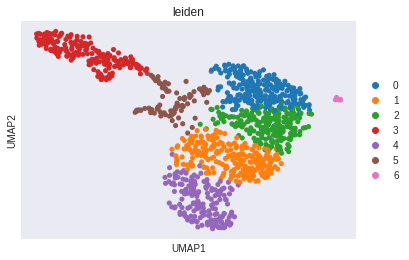

In [72]:
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'])


In [73]:
for i in range(theta.shape[1]):
    adata.obs['lda_'+str(i)]=theta[:,i]


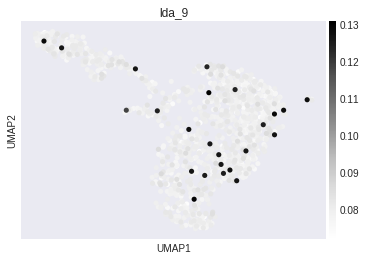

In [75]:
sc.pl.umap(adata, color=['lda_9'])


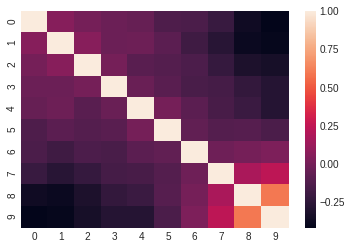

In [65]:
sns.heatmap(np.corrcoef(theta.T))

TypeError: only integer scalar arrays can be converted to a scalar index

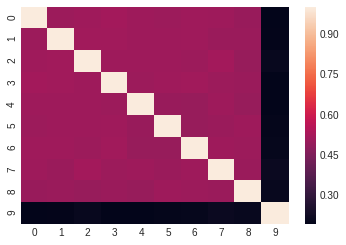

In [63]:
def print_top_words(beta, feature_names, n_top_words=10):
    for i in range(len(beta)):
        print(("Topic #%d: " % i) + " ".join([feature_names[j]
            for j in beta[i].argsort()[:-n_top_words - 1:-1]]))


beta_pymc3 = np.concatenate([np.mean(advi_fit.sample(20)['beta'],axis=0),betaAmbient],axis=0)
sns.heatmap(np.corrcoef(beta_pymc3))
print_top_words(beta_pymc3, feature_names)

In [ ]:
sns.distplot(samples['theta'].mean(axis=0)[:,9],kde=False,bins=20)